Code verifies consistency after replicates

This notebook shwos with high liklihood there's a violator where fx is near/greater than 1, but falls well below the line in 180 replicates

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import glob
import BootstrapFunctions as bsf
sns.set_context('talk')

In [4]:
folders = glob.glob('Data/Replicate_IntHill/*/*')
dat = []
failedsims = []
bootstrapdicts = []
intparamlist = ['lambda','beta_x','gamma','beta_y','alpha','beta_z','nx','Kx','ny','Ky','offset']
#List out the perturbation types: u is up, d is down, n is none. l for lambda, g for gamma.  Add 1,2 to balance the neutral points
pertcases = {"lngn":[0,1,2],"lngu":[3,4,5],"lngd":[6,7,8],
             "lugn":[9,10,11],"lugu":[12,13,14],"lugd":[15,16,17],
             "ldgn":[18,19,20],"ldgu":[21,22,23],"ldgd":[24,25,26]}
oneparamperts = pertcases["lngn"]+pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]
no_nonperts = pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]
inv_pertcases = {v_int:k for k, v in pertcases.items() for v_int in v}
twovarparamlist = ['lambda','beta_x','gamma','beta_y','nx','Kx','ny','Ky','offset']
threevarparamlist = ['lambda','beta_x','gamma','beta_y','alpha','beta_z','nx','Kx','ny','Ky','offset']
byfilelist = ['fileN','fileda','filedb','sysname']

for i,folder in enumerate(folders):
    files = glob.glob(folder+'/*data.csv',recursive=True)
    for j,f in enumerate(files):
        data = pd.read_csv(f)
        data = data.reset_index().rename(columns={'index':'perturbation'})
        numstrings = f.split("_")[-2].split('n')
        data['fileN'] = float(numstrings[0])
        data['fileda'] = float(numstrings[1])
        data['filedb'] = float(numstrings[2])
        data['sysname'] = "/".join(f.split("/")[:-1])
        data.rename(columns={'F_<x>':'F_<x> (wrong)','F_<y>':'F_<y> (wrong)'},inplace=True)
        if (data[['Cov Bal xx','Cov Bal yy','Cov Bal xy','Cov Bal xz','Cov Bal yz','Cov Bal zz']] > 0.05).any(axis=1).any():
            failedsims.append(f)
            continue
        dat.append(data)
        bsdict = bsf.pertexp_interpret(data,20000,analysed_columns=['<x>','<y>','<z>',"<F_x>","<F_y>"])
        bsdict['fileN'] = float(numstrings[0])
        bsdict['fileda'] = float(numstrings[1])
        bsdict['filedb'] = float(numstrings[2])
        bsdict['sysname'] = "/".join(f.split("/")[:-1])
        for p in intparamlist:
            bsdict[p] = data[p][0]
        bootstrapdicts.append(bsdict)
analysed_data = pd.concat(dat)

#analysed_data = analysed_data[(analysed_data["filedb"]>=0.005)&(analysed_data["fileda"]>=0.005)]

analysed_data['perturbation class'] = analysed_data['perturbation'].apply(lambda x: inv_pertcases[x])
pertdata_int = analysed_data.set_index(["fileN",'fileda','filedb','sysname','perturbation','perturbation class'])

In [5]:
intbootstrapped_res = pd.DataFrame(bootstrapdicts)
intbootstrapped_res.set_index(["fileN",'fileda','filedb','sysname'],inplace=True)

<Axes: >

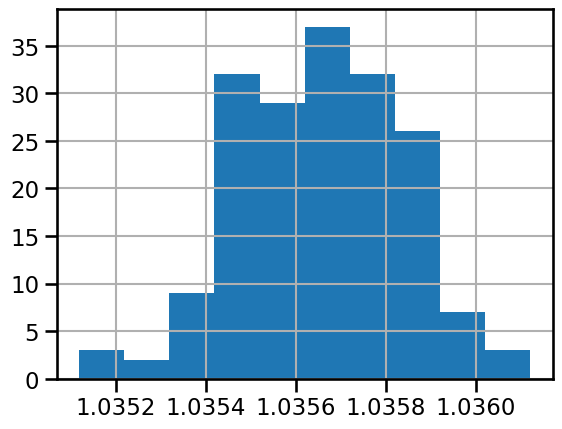

In [21]:
intbootstrapped_res['E[<F_x>]'].hist()

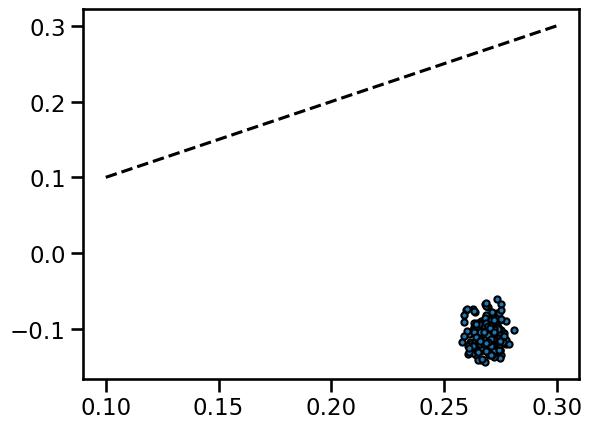

In [19]:
plt.scatter(1/intbootstrapped_res['E[CVx/CVy]'],intbootstrapped_res['E[rhoxy]'],s=20,edgecolors='k')
plt.plot(np.linspace(0.1,0.3),np.linspace(0.1,0.3),'k--')